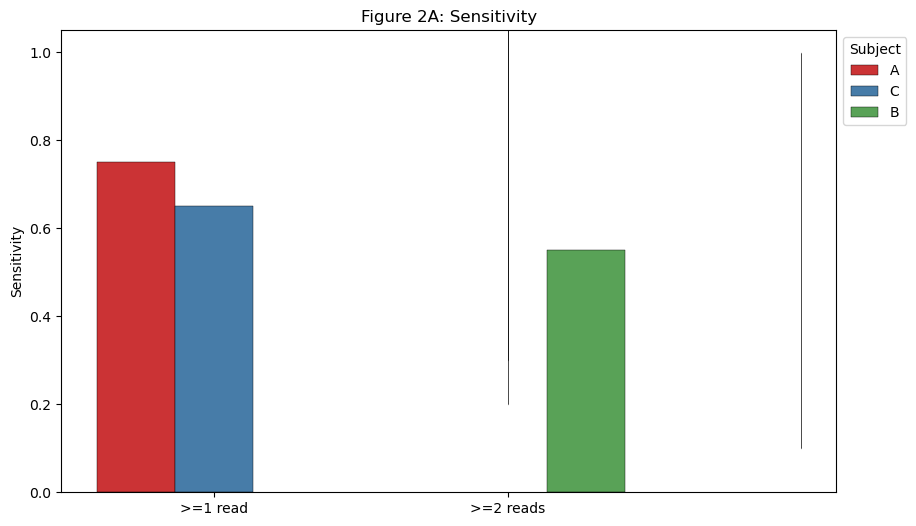

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import numpy as np

def summarySE(data=None, measurevar=None, groupvars=None, na_rm=False, conf_interval=0.95):
    # New version of length which can handle NA's: if na_rm==True, don't count them
    def length2(x, na_rm=False):
        if na_rm:
            return np.sum(~np.isnan(x))
        else:
            return len(x)

    # This does the summary. For each group's data frame, return a DataFrame with N, mean, and sd
    def summary_fun(xx, col):
        return pd.Series({
            'N': length2(xx[col], na_rm=na_rm),
            'mean': np.mean(xx[col]),
            'sd': np.std(xx[col])
        })

    datac = data.groupby(groupvars, dropna=True).apply(summary_fun, col=measurevar).reset_index()

    # Rename the "mean" column
    datac.rename(columns={'mean': measurevar}, inplace=True)

    datac['se'] = datac['sd'] / np.sqrt(datac['N'])  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval:
    # e.g., if conf_interval is 0.95, use 0.975 (above/below), and use df=N-1
    ci_mult = t.ppf(conf_interval / 2 + 0.5, datac['N'] - 1)
    datac['ci'] = datac['se'] * ci_mult

    return datac 


# Example data (replace these paths with your actual data paths)
L1_data = {
    'subject': ['A', 'B', 'C'],
    'support': [1, 2, 1],
    'recall': [0.8, 0.6, 0.7]
}

L2_data = {
    'subject': ['A', 'B', 'C'],
    'support': [1, 2, 1],
    'recall': [0.7, 0.5, 0.6]
}

L1 = pd.DataFrame(L1_data)
L2 = pd.DataFrame(L2_data)

LINE = pd.concat([L1, L2], ignore_index=True)

# Calculate summary statistics
sum_sens = summarySE(LINE, measurevar="recall", groupvars=["subject", "support"])

# Plot sensitivity
plt.figure(figsize=(10, 6))
sns.barplot(x="support", y="recall", hue="subject", data=sum_sens, dodge=True, palette="Set1", edgecolor="black", linewidth=0.3)
#sns.errorbar(x=sum_sens['support'], y=sum_sens['recall'], yerr=sum_sens['ci'], fmt='none', color='black', capsize=0.1, linewidth=0.5)
plt.errorbar(x=sum_sens['support'], y=sum_sens['recall'], yerr=sum_sens['ci'], fmt='none', color='black', capsize=0.1, linewidth=0.5)


plt.xlabel("")
plt.ylabel("Sensitivity")
plt.ylim(0, 1.05)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([0, 1], labels=[">=1 read", ">=2 reads"])
plt.legend(title="Subject", bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Figure 2A: Sensitivity")
plt.show()
